# Solving Sudokus with ShuffleSoftSort
This notebook demonstrates the Gradient-based sollving of Sudoku from the paper:
<p>
Kai Barthel, Florian Tim Barthel, Peter Eisert
<br>
HTW Berlin, Visual Computing Group, Germany and Fraunhofer HHI    
<p>
<b> "Permutation Learning with Only N Parameters: From SoftSort to Self-Organizing Gaussians" </b>
<p>
Solving Sudokus in an unsupervised environment (without ground truth) or learning from large sets of example problems is a difficult problem. The presented approach works for easy to moderately difficult problems. For very hard Sudokus, solutions may not be found, but the algorithm finds number arrangements with very few violations of the Sudoku rules.

 ## 1. Configuration & Setup

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Dict

In [23]:
class Config:
    """Configuration settings for the Sudoku solver."""
    seed: int = 42         # depending on the seed the solving time may differ
    log_every: int = 100  # How often to log results during solving.
    iterations: int = 5  # SoftSort iterations.
    runs: int = 10000  # Max attempts to solve the puzzle.
    learning_rate: float = 0.2
    tau: float = 0.5  # Temperature for SoftSort.
    l_std: float = 0.5  # Weight for the standard deviation loss.
    l_constraint: float = 100.0  # Weight for the permutation matrix constraint loss.
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
# A collection of sample puzzles.
SUDOKU_PUZZLES: Dict[str, List[List[int]]] = {
    "easy": [
        [0, 1, 3, 0, 0, 6, 0, 0, 0], [5, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 5, 7, 0, 3, 9, 4],
        [3, 2, 9, 0, 0, 4, 0, 0, 0], [4, 0, 0, 0, 0, 0, 0, 2, 1], [6, 8, 0, 0, 0, 0, 0, 5, 0],
        [1, 0, 8, 6, 9, 0, 7, 0, 0], [0, 3, 0, 0, 8, 2, 0, 0, 0], [2, 9, 0, 0, 0, 3, 6, 4, 0]
    ],
    "moderate": [
        [5, 3, 0, 0, 7, 0, 0, 0, 0], [6, 0, 0, 1, 9, 5, 0, 0, 0], [0, 9, 8, 0, 0, 0, 0, 6, 0],
        [8, 0, 0, 0, 6, 0, 0, 0, 3], [4, 0, 0, 8, 0, 3, 0, 0, 1], [7, 0, 0, 0, 2, 0, 0, 0, 6],
        [0, 6, 0, 0, 0, 0, 2, 8, 0], [0, 0, 0, 4, 1, 9, 0, 0, 5], [0, 0, 0, 0, 8, 0, 0, 7, 9]
        ],
    "hard": [
        [0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 5, 7, 6, 0], [0, 0, 7, 1, 0, 0, 0, 5, 3],
        [0, 0, 0, 4, 1, 0, 0, 2, 0], [0, 0, 3, 0, 0, 0, 4, 0, 0], [0, 9, 0, 0, 6, 8, 0, 0, 0],
        [2, 8, 0, 0, 0, 4, 9, 0, 0], [0, 1, 5, 6, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0]
    ],
    "paper1": [ # Sinkhorn Solves Sudoku https://www.researchgate.net/publication/224396653_Sinkhorn_Solves_Sudoku
        [0, 0, 3, 0, 0, 9, 0, 8, 1], [0, 0, 0, 2, 0, 0, 0, 6, 0], [5, 0, 0, 0, 1, 0, 7, 0, 0],
        [8, 9, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 6, 0, 1, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 3, 7],
        [0, 0, 9, 0, 2, 0, 0, 0, 8], [0, 7, 0, 0, 0, 4, 0, 0, 0], [2, 5, 0, 8, 0, 0, 6, 0, 0]
    ],
    "paper2": [ # SUDOQ — A QUANTUM VARIANT OF THE POPULAR GAME   arXiv:2005.10862v1
        [0, 0, 3, 0, 2, 0, 6, 0, 0], [9, 0, 0, 3, 0, 5, 0, 0, 1], [0, 0, 1, 8, 0, 6, 4, 0, 0],
        [0, 0, 8, 1, 0, 2, 9, 0, 0], [7, 0, 0, 0, 0, 0, 0, 0, 8], [0, 0, 6, 7, 0, 8, 2, 0, 0],
        [0, 0, 2, 6, 0, 9, 5, 0, 0], [8, 0, 0, 2, 0, 3, 0, 0, 9], [0, 0, 5, 0, 1, 0, 3, 0, 0]
    ]
}

In [25]:
def set_global_seed(seed: int) -> None:
    """ Sets the random seed for reproducibility. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        

## 2. The ShuffleSoftSort Neural Network

In [26]:
class SoftSortNetwork(nn.Module):
    """
    A network that learns to permute elements within distinct blocks of a vector
    using a differentiable soft sorting mechanism.
    """

    def __init__(self, block_sizes: torch.Tensor, device: torch.device):
        """
        Args:
            block_sizes: A tensor containing the size of each block to be sorted.
            device: The device to place tensors on (e.g., 'cpu' or 'cuda').
        """
        super().__init__()
        self.block_sizes = block_sizes
        self.total_length = block_sizes.sum().item()

        # Use a ParameterList to handle a dynamic list of parameters.
        self.weights = nn.ParameterList([
            nn.Parameter(torch.arange(0., size, device=device)) for size in self.block_sizes
        ])

    def forward(self, tau: float = 1.0) -> torch.Tensor:
        """
        Generates a block-diagonal soft permutation matrix.
        Args:
            tau: The temperature parameter for the softmax function.
        Returns:
            A (total_length, total_length) block-diagonal permutation matrix.
        """
        perm_matrix = torch.zeros(self.total_length, self.total_length, device=self.weights[0].device)
        start_idx = 0
        for i, block_size in enumerate(self.block_sizes):
            end_idx = start_idx + block_size

            w = self.weights[i].view(-1, 1)
            w_sorted = w.sort(descending=False, dim=0)[0]

            # Pairwise differences 
            pairwise_diff = (w.T - w_sorted).abs().neg() / tau

            # Softmax produces a differentiable soft permutation matrix for the block
            p_block = pairwise_diff.softmax(-1) 

            perm_matrix[start_idx:end_idx, start_idx:end_idx] = p_block
            start_idx = end_idx

        return perm_matrix

## 3. Sudoku Helper and Pre-processing Functions

In [27]:
def get_sudoku_inputs(board: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Analyzes a Sudoku board to find the numbers needed to fill empty cells.

    Args:
        board: A 9x9 tensor representing the Sudoku board (0 for empty cells).
    Returns:
        A tuple containing:
        - fill_numbers: A 1D tensor of all numbers required to fill empty cells, grouped by row.
        - row_fill_counts: A 1D tensor with the count of missing numbers per row.
        - zero_mask: A 9x9 boolean mask where True indicates an empty cell.
    """
    all_expected = set(range(1, 10))
    fill_numbers_list = []
    row_fill_counts_list = []

    for row in board:
        present_numbers = set(cell.item() for cell in row if cell != 0)
        missing_numbers = sorted(list(all_expected - present_numbers))
        random.shuffle(missing_numbers)
        fill_numbers_list.extend(missing_numbers)
        row_fill_counts_list.append(len(missing_numbers))

    fill_numbers = torch.tensor(fill_numbers_list, dtype=torch.int)
    row_fill_counts = torch.tensor(row_fill_counts_list, dtype=torch.int)
    zero_mask = (board == 0)

    return fill_numbers, row_fill_counts, zero_mask

In [28]:
def count_sudoku_errors(board: torch.Tensor) -> int:
    """
    Counts the total number of cells that violate Sudoku rules on a filled board.
    An error is counted for any cell containing a number that is a duplicate
    in its row, column, or 3x3 block.
    These errors are only the number of violations and not the actual errors compared
    to the Sudoku solution (which is unknown), that number is typically higher.

    Args:
        board: A 9x9 tensor representing the filled Sudoku board.
    Returns:
        The total number of sododu errors (Sudoku violations).
    """

    blocks_extracted = board.reshape(3, 3, 3, 3).swapaxes(1, 2).reshape(9, 9) 
    num_errors = 0
    
    # Check for errors (duplicates of numbers) in rows, cols and blocks
    for i in range(9):
        # we do not need to check the rows, they are no errors due to the row wise approach

        # Check column 'i'
        col = board[:, i]
        unique_vals_col = torch.unique(col)
        num_errors += 9 - unique_vals_col.numel()

        # Check for errors in each 3x3 block
        block = blocks_extracted[i]
        unique_vals_block = torch.unique(block)
        num_errors += 9 - unique_vals_block.numel()

    return num_errors
    

In [29]:
def draw_sudoku(initial_board: torch.Tensor, final_board: torch.Tensor):
    """Visualizes the solved Sudoku board with highlighted numbers."""
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(0, 9, 1), minor=True)
    ax.set_yticks(np.arange(0, 9, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)

    for i in range(9):
        for j in range(9):
            num = final_board[i, j].item()
            if num != 0:
                color = 'blue' if initial_board[i, j] == 0 else 'black'
                ax.text(j + 0.5, 8.5 - i, str(num), va='center', ha='center', fontsize=16, color=color)

    # Thicken the 3x3 box borders
    for i in range(0, 10, 3):
        ax.axhline(i, color='black', linewidth=3)
        ax.axvline(i, color='black', linewidth=3)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()


In [30]:
def draw_sudoku(initial_board: torch.Tensor, final_board: torch.Tensor = None):
    """
    Visualizes a Sudoku board, highlighting clues in black, correct answers in blue,
    and errors in red. This version correctly identifies and highlights all errors,
    including those in the initial clues.
    These errors are only the number of violations and not the actual errors compared
    to the Sudoku solution (which is unknown), that number is typically higher.

    Args:
        initial_board: A 9x9 tensor representing the initial Sudoku board.
        final_board: An optional 9x9 tensor representing the solved or partially solved board.
    """
    board_to_draw = final_board if final_board is not None else initial_board

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(0, 9, 1), minor=True)
    ax.set_yticks(np.arange(0, 9, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)

    for i in range(0, 10, 3):
        ax.axhline(i, color='black', linewidth=3)
        ax.axvline(i, color='black', linewidth=3)

    if final_board is not None:
        error_mask = torch.zeros_like(final_board, dtype=torch.bool)

        for r in range(9):
            for c in range(9):
                value = final_board[r, c].item()
                if value == 0:
                    continue

                # Check row for duplicates
                row_slice = final_board[r, :]
                if torch.sum(row_slice == value) > 1:
                    error_mask[r, c] = True

                # Check column for duplicates
                col_slice = final_board[:, c]
                if torch.sum(col_slice == value) > 1:
                    error_mask[r, c] = True

                # Check 3x3 block for duplicates
                r_start, c_start = (r // 3) * 3, (c // 3) * 3
                block_slice = final_board[r_start:r_start+3, c_start:c_start+3]
                if torch.sum(block_slice == value) > 1:
                    error_mask[r, c] = True

    for i in range(9):
        for j in range(9):
            num = board_to_draw[i, j].item()
            if num != 0:
                color = 'black'  # Default color for clues and correct user-entered numbers

                if final_board is not None:
                    # If it's an error, it's always red
                    if error_mask[i, j]:
                        color = 'red'
                    # If not an error, determine if it's a clue or a correct guess
                    else:
                        color = 'black' if initial_board[i, j] != 0 else 'blue'

                ax.text(j + 0.5, 8.5 - i, str(num), va='center', ha='center', fontsize=16, color=color)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

## 4. Loss Functions

In [31]:
def permutation_constraint_loss(perm_matrix: torch.Tensor) -> torch.Tensor:
    """Enforces the doubly stochastic property of the permutation matrix."""
    return torch.mean((perm_matrix.sum(dim=0) - 1) ** 2) + torch.mean((perm_matrix.sum(dim=1) - 1) ** 2)
    

In [32]:
def sudoku_rule_loss(p_tensor: torch.Tensor) -> torch.Tensor:
    """
    Calculates the loss based on Sudoku rule violations for a single 9x9 board,
    with all components (rule_loss and clue_loss) fully vectorized.

    Args:
        p_tensor: A (9, 9, 9) tensor where P[k, r, c] is the probability of digit k+1 at cell (r, c).
                  Assumes p_tensor is already on the correct device (CPU/GPU).
        initial_board: The initial board with clues. (9, 9) tensor of torch.long type.
                       Assumes initial_board is already on the correct device (CPU/GPU).

    Returns:
        A scalar loss value.
    """

    loss = 0.0

    # --- 1. Rule Loss (Row, Column, Block sums of probabilities) ---
    # p_tensor shape: (Digit, Row, Col)

    # Row sums: Sum over column dimension (dim=2)
    # Result shape: (Digit, Row)
    row_sums = p_tensor.sum(dim=2)
    loss += ((row_sums - 1.0) ** 2).sum()

    # Column sums: Sum over row dimension (dim=1)
    # Result shape: (Digit, Col)
    col_sums = p_tensor.sum(dim=1)
    loss += ((col_sums - 1.0) ** 2).sum()

    # Block sums for rule loss and later for clue loss
    # Reshape p_tensor: (Digit, 9, 9) -> (Digit, 1, 9, 9) for unfold
    p_tensor_for_unfold = p_tensor.unsqueeze(1)  # Adds a channel dimension (C=1)

    # Output shape of unfold: (Digit, 1 * 3 * 3, 3 * 3) -> (9, 9, 9)
    # (Digit, Flattened_Block_Elements, Block_Index)
    blocks_extracted = F.unfold(p_tensor_for_unfold, kernel_size=(3, 3), stride=(3, 3))

    # Sum each flattened 3x3 block along the second dimension (the 9 elements)
    # Result shape: (Digit, 9) -> (Digit, Block_Index)
    block_sums = blocks_extracted.sum(dim=1)
    loss += ((block_sums - 1.0) ** 2).sum()

    return loss

In [33]:
def total_loss(p_tensor: torch.Tensor, perm_matrix: torch.Tensor, soft_filled_board: torch.Tensor, initial_board: torch.Tensor, cfg: Config) -> torch.Tensor:
    """Aggregates all loss components."""
    loss_sudoku = sudoku_rule_loss(p_tensor)
    loss_constraint = cfg.l_constraint * permutation_constraint_loss(perm_matrix)

    # Standard deviation loss for regularization
    # This tries to make the predicted numbers for empty cells have the spread of the numbers 1-9
    std_target = 2.739  # Pre-calculated target std deviation for numbers 1-9
    # If soft_filled_board is 9x9, torch.std(dim=1) will get std of each row.
    loss_std = cfg.l_std * (((torch.std(soft_filled_board.float(), dim=1) - std_target) / std_target) ** 2).sum()

    return loss_sudoku + loss_constraint + loss_std

##  5. Matrix Transformation Utilities

In [34]:
def compute_p_tensor(
        perm_soft_shuffled: torch.Tensor,
        x_shuffled: torch.Tensor,
        inv_shuffled_indices: torch.Tensor,
        initial_board: torch.Tensor,
        zero_mask: torch.Tensor
) -> torch.Tensor:
    """
    Constructs a 3D digit probability tensor for a Sudoku board from a
    shuffled permutation matrix and the initial board clues.

    This function first calculates the probability distribution for the
    empty (non-clue) cells of the board. It then combines these probabilities
    with the one-hot encoded representation of the initial clues to form a
    complete probability tensor.

    Args:
        perm_soft_shuffled: A (k, k) soft permutation matrix for the empty cells,
                            where k is the number of empty cells. This matrix is
                            shuffled according to a specific permutation.
        x_shuffled: A 1D tensor (length k) containing the digit values (1-9)
                    assigned to the empty cells, also shuffled.
        inv_shuffled_indices: A 1D tensor (length k) of inverse indices to
                              un-shuffle the results back to the original order of
                              the empty cells.
        initial_board: A (9, 9) tensor representing the initial Sudoku board,
                       with zeros for empty cells.
        zero_mask: A (9, 9) boolean mask where True indicates an empty cell
                   (a zero) in the initial board.

    Returns:
        A (9, 9, 9) tensor where p_tensor[d, r, c] is the probability of digit d+1
        at position (r, c). For clue cells, the probability is 1 for the correct
        digit and 0 for all others. For empty cells, it's the calculated probability
        distribution.
    """
    k = perm_soft_shuffled.shape[0]
    device = perm_soft_shuffled.device
    dtype = perm_soft_shuffled.dtype

    # --- Step 1: Calculate probability distribution for the `k` empty cells ---
    # We sum the columns of `perm_soft_shuffled` based on the digit value in `x_shuffled`.
    # This gives the probability of each empty cell being assigned each digit.
    P_T = perm_soft_shuffled.T
    group_indices = x_shuffled.long() - 1

    # prob_dist_T will have shape (9, k), where prob_dist_T[d, i] is the probability
    # that the i-th shuffled empty cell gets digit d+1.
    prob_dist_T = torch.zeros((9, k), device=device, dtype=dtype)
    prob_dist_T.index_add_(0, group_indices, P_T)

    # Un-shuffle the probability distributions to match the original board's empty cell order.
    unshuffled_prob_dist_T = prob_dist_T[:, inv_shuffled_indices]

    # --- Step 2: Create the final p_tensor ---
    # Start with a tensor representing only the fixed clues (1s for clues, 0s elsewhere).
    p_tensor = torch.nn.functional.one_hot(initial_board.long(), num_classes=10)[:, :, 1:].permute(2, 0, 1).float()

    # Insert the calculated probabilities for the empty cells.
    p_tensor.view(9, 81)[:, zero_mask.flatten()] = unshuffled_prob_dist_T

    return p_tensor

## 6. Main Solver Function

In [35]:
def solve_sudoku(initial_board: torch.Tensor, cfg: Config) -> Tuple[torch.Tensor, int]:
    """
    Attempts to solve a Sudoku puzzle using the ShuffleSoftSort technique.

    Args:
        initial_board: A 9x9 tensor of the puzzle to solve.
        cfg: The configuration object.

    Returns:
        A tuple containing:
        - The solved 9x9 board tensor.
        - The number of errors in the final solution (0 if successful).
    """
    # --- Setup ---
    # `fill_numbers`: the 1D tensor of values (1-9) that need to fill empty cells, grouped by row
    # `row_fill_counts`: the number of empty cells in each row
    # `zero_mask`: a 9x9 boolean mask indicating empty cells
    fill_numbers, row_fill_counts, zero_mask = get_sudoku_inputs(initial_board)
    x = fill_numbers.float().to(cfg.device) # The values to be permuted (candidates for empty cells)

    board_vec = initial_board.flatten() # Flat initial board (includes zeros for empty cells)
    clue_indices = board_vec.nonzero().flatten() # Indices of the fixed clues on the flattened board

    total_steps = 0
    final_solved_board = initial_board.clone().int() # Initialize with initial board
    best_errors = 81 # Max possible errors

    for run in range(cfg.runs):
        net = SoftSortNetwork(row_fill_counts, device=cfg.device).to(cfg.device)
        optimizer = torch.optim.Adam(net.parameters(), lr=cfg.learning_rate)

        # --- Prepare for this run: Randomly shuffle sections of x for diversity ---
        # `indices`: A 1D tensor [0, 1, ..., x.numel()-1]
        indices = torch.arange(x.numel(), device=cfg.device)
        # Split `indices` into sections corresponding to `row_fill_counts`, then shuffle each section.
        # This ensures that numbers stay within their original rows' candidate pools,
        # but their order within that pool is randomized for exploration.
        shuffled_indices = torch.cat([
            s_part[torch.randperm(len(s_part))]
            for s_part in indices.split(row_fill_counts.tolist())
        ])
        x_shuffled = x[shuffled_indices] # Apply this shuffle to the actual numbers `x`

        # Get the inverse of the shuffled indices to revert later
        inv_shuffled_indices = torch.argsort(shuffled_indices)

        iteration = 0
        while True:
            iteration += 1
            total_steps += 1
            optimizer.zero_grad()

            # --- Forward Pass ---
            # 1. Get the soft permutation matrix for the shuffled variable values
            perm_soft_shuffled = net(cfg.tau)

            # 2. Compute the (9,9,9) probability tensor for the loss function.
            p_tensor = compute_p_tensor(perm_soft_shuffled, x_shuffled, inv_shuffled_indices, initial_board, zero_mask)

            # --- Loss Calculation & Backward Pass ---
            # Get the soft-filled board for the std_dev loss component
            soft_filled_board = initial_board.clone().float()
            soft_filled_board[zero_mask] = (perm_soft_shuffled @ x_shuffled)[inv_shuffled_indices]

            # Pass the `perm_soft_shuffled` (not `perm_full`) for constraint loss as it's the network's output.
            loss = total_loss(p_tensor, perm_soft_shuffled, soft_filled_board, initial_board, cfg)
            loss.backward()
            optimizer.step()

            # --- Check for Solution (using hard assignments) ---
            # Get the hard permutation (actual assigned indices)
            hard_perm_indices = torch.argmax(perm_soft_shuffled, dim=-1) # indices for x_shuffled

            num_duplicates = x.numel() - torch.unique(hard_perm_indices).numel()

            # Apply hard permutation to x_shuffled to get solved values for empty cells
            x_solved_shuffled = x_shuffled[hard_perm_indices]
            # Unshuffle these solved values to match the original board's empty positions
            x_solved_original_order = x_solved_shuffled[inv_shuffled_indices]

            # Create the actual filled board for error counting
            current_filled_board_hard = initial_board.clone()
            current_filled_board_hard[zero_mask] = x_solved_original_order.int()

            num_errors = count_sudoku_errors(current_filled_board_hard)
            # num_errors = count_sudoku_errors_vectorized_no_row_check(current_filled_board_hard)

            if num_errors < best_errors:
                best_errors = num_errors
                final_solved_board = current_filled_board_hard.clone()

            if run % cfg.log_every == 0 and (num_errors == 0 or iteration >= cfg.iterations):
                print(f"Run: {run:4d} | Loss: {loss.item():5.2f} | Errors: {num_errors:2d}")

            # --- Termination Condition for inner loop ---
            # Break if a perfect solution is found OR if permutations are unique and min iterations are done
            if num_errors == 0 or (num_duplicates == 0 and iteration >= cfg.iterations):
                break

        # --- Termination Condition for outer loop ---
        # If a solution (0 errors) is found in any run, stop.
        if num_errors == 0:
            print(f"Run: {run:4d} | Loss: {loss.item():5.2f} | Errors: {num_errors:2d}")
            print(f"\nSolution found!")
            return final_solved_board, 0

        x[shuffled_indices] = x_shuffled[hard_perm_indices]

    print("\nSolver finished. No solution found within the given runs.")
    return final_solved_board, best_errors

## 7. Main Execution Block


Initial Board:


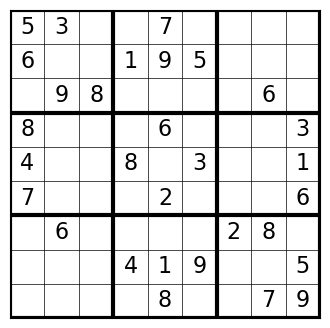

Run:    0 | Loss: 37.85 | Errors: 33
Run:  100 | Loss:  3.91 | Errors:  2
Run:  141 | Loss:  2.01 | Errors:  0

Solution found!
1.53 seconds

Final Board with 0 errors:


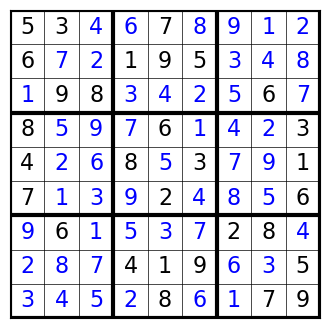

In [41]:
# --- 1. Initialize ---
cfg = Config()
set_global_seed(cfg.seed)  
# print(f"Using device: {cfg.device}")

# --- 2. Select and Prepare Puzzle ---
puzzle_name = "moderate"  # Choose from "easy", "moderate", "hard", "paper1", "paper2"
initial_board = torch.tensor(SUDOKU_PUZZLES[puzzle_name], dtype=torch.int, device=cfg.device)

print("\nInitial Board:")
draw_sudoku(initial_board.cpu())

# --- 3. Run Solver ---
start_time = time.time()
solved_board, errors = solve_sudoku(initial_board, cfg)
end_time = time.time()
duration = time.time() - start_time
print(f"{duration:.2f} seconds")

# --- 4. Display Results ---
print(f"\nFinal Board with {errors} errors:")

draw_sudoku(initial_board.cpu(), solved_board.cpu())